# Learning Theory from First Principles

## Chapter 5 : Optimization

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures

#### Fig 5.1

In [ ]:
#Problem setup
n = 100
d = 1000
sd_noise = 0.25

#Design matrix Phi
def Phi(p): #p = power
    D = np.diag([np.sqrt(n/k**(p)) for k in range(1,d+1)])
    U = ortho_group.rvs(dim=d)
    Phi = U @ D @ U.T
    return Phi

def generateData(t, k):
    np.random.seed(1)
    Phi_k = Phi(p=k)
    H_k = (Phi_k.T @ Phi_k)/n

    #Random true nu
    nu = np.random.uniform(-1, 1, d)
    #Calculate y and y_observed
    y_true = Phi_k.dot(nu)
    noise = np.random.normal(0, np.sqrt(1), d)
    yfix_noisy = y_true + noise*sd_noise
    #max eigval of H: L=1
    L = 1

    #Gradient descent
    gamma = 1/L
    th0 = nu + np.random.normal(0, sd_noise, d)

    if np.linalg.norm(th0-nu, 2) > 8*gamma:
        print("Norm not small enough")
        exit()

    #simpler form for F(th)-F(nu)
    A = th0 - nu
    B = np.eye(d) - gamma*H_k
    lB, U = np.linalg.eig(B)    #Decomp for fast powers
    U_inv = np.linalg.inv(U)
    lB = np.diag(lB)
    C = H_k @ A
    def F(t):
        Lambda = (np.sign(lB)*np.abs(lB))**(2*t)   #avoid python runtime error
        D = U @ Lambda @ U_inv
        return 0.5 * A.T @ (D @ C)
    F = np.vectorize(F)

    return nu, th0, F(t)

t = np.arange(1, 5101, step=100)
nu, th0, Gt_k1 = generateData(t, k=1)
nu1, th01, Gt_k2 = generateData(t, k=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

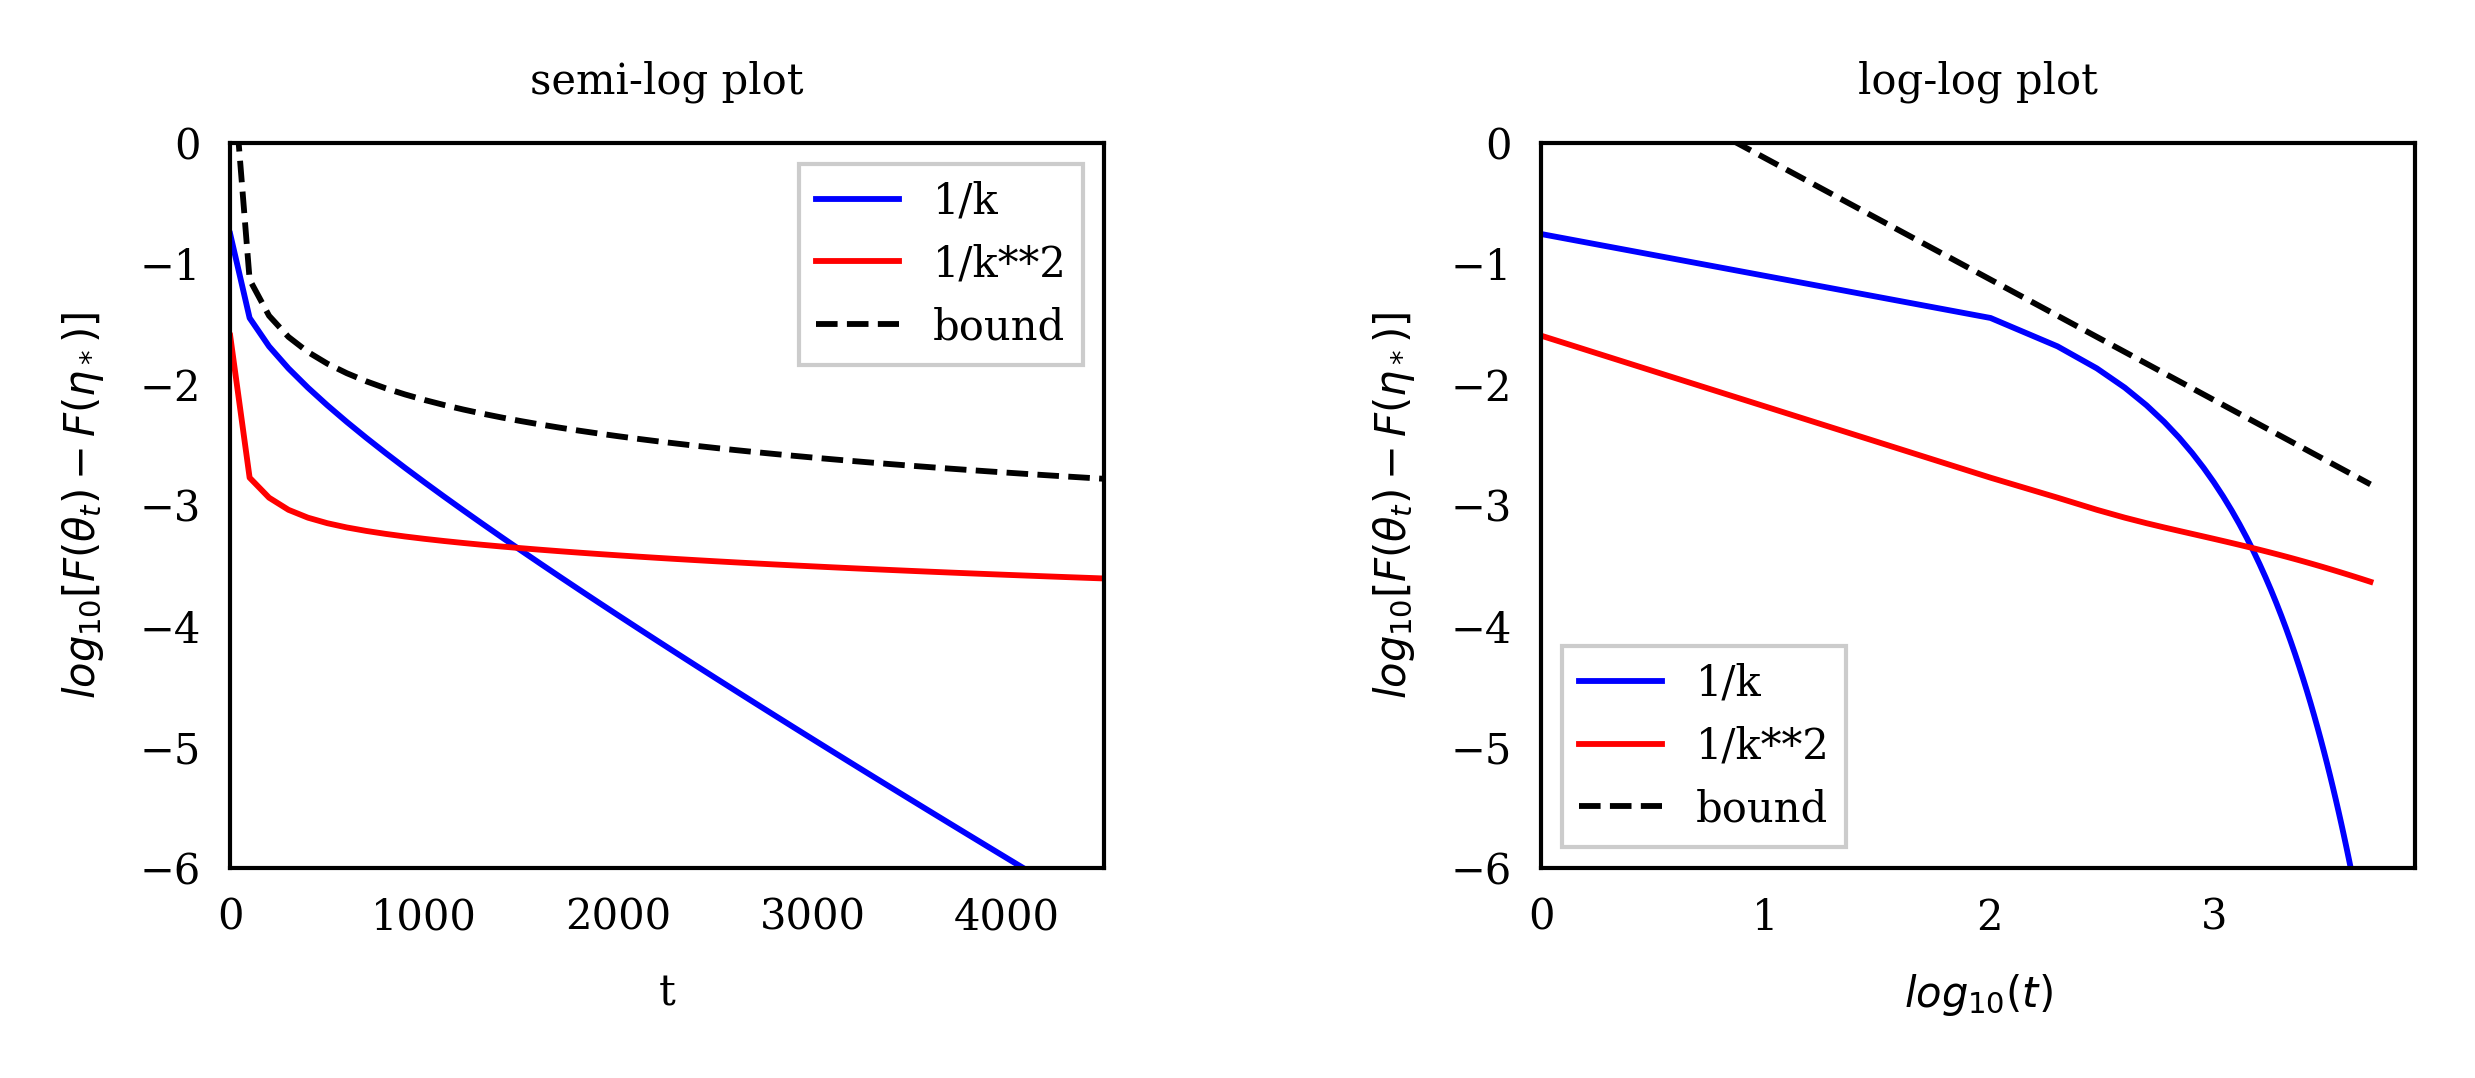

In [ ]:
# Bound
B = lambda t, gam=1 : 1/(8*t*gam) * np.linalg.norm(th0-nu, 2)**2
B = np.vectorize(B)

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=medium_rectangle, gridspec_kw = inner_space)

l10 = np.log10
axs1.plot(t, l10(Gt_k1), 'b', label='1/k')
axs1.plot(t, l10(Gt_k2), 'r', label='1/k**2')
axs1.plot(t, l10(B(t)), 'k--', label='bound')
axs1.set_xlabel("t")
axs1.set_ylabel('$log_{10}[F(\\theta_t) - F(\eta_*)]$')
axs1.legend()
axs1.set_xlim(0., 4500)
axs1.set_ylim(-6., 0.)
axs1.set_title("semi-log plot")

axs2.plot(l10(t),l10(Gt_k1), 'b', label='1/k')
axs2.plot(l10(t), l10(Gt_k2), 'r', label='1/k**2')
axs2.plot(l10(t), l10(B(t)), 'k--', label='bound')
axs2.set_xlabel('$log_{10}(t)$')
axs2.set_ylabel('$log_{10}[F(\\theta_t) - F(\eta_*)]$')
axs2.legend()
axs2.set_xlim(0., 3.9)
axs2.set_ylim(-6., 0.)
axs2.set_title("log-log plot");

plt.savefig('fig51.svg')
files.download("fig51.svg")


#### Fig 5.2

In [ ]:
n = 400
d = 40

def F(y,theta,X,mu):
    return np.sum(hinge(y* (X).dot(theta)))/n + mu*np.sum(theta**2)/2

def gt(i,mu,theta,y,X):
    if y[i]*np.transpose(theta).dot(X[i,:])>1:
        return mu*theta
    else :
        return mu*theta - y[i]*X[i,:]

H = np.random.normal(0, 1, (d,d))
U, S, V = np.linalg.svd(H)
H = U @ np.diag([1/i for i in range(1,d+1)]) @ U.T
H2 = U @ np.diag([1/i**2 for i in range(1,d+1)]) @ U.T
Hsqrt = U @ np.diag([1/np.sqrt(i) for i in range(1,d+1)]) @ U.T

x = np.random.normal(0, 1, (n,d)) @ Hsqrt
nu = np.random.normal(0, 1, d)
nu = nu / np.sqrt(nu.T @ H @ nu)
noise_std = 1
y = np.sign(x @ nu + noise_std * np.random.normal(0,1,n))
R = np.max(np.sum(x**2, axis=1))

def onerun(max_iter, mu, gam_choice, n):
    w = 0.1*np.ones(d)
    Fstar = np.zeros(max_iter)
    for t in range(1,max_iter):
        if gam_choice == 1:
            gamma = 1/(mu*t)
        else:
            gamma = 1/(R*(t**0.5))
        i = np.random.randint(n) - 1
        w = w - gamma*gt(i,mu,w,y,x)
        Fstar[t] = F(y,w,x,mu)
    return Fstar

max_iter = 10000
#MU1
mu1 = 0.001
F1_mu = onerun(max_iter, mu1, 1, n)
F1_R = onerun(max_iter, mu1, 2, n)
#MU2
mu2 = 0.1
F2_mu = onerun(max_iter, mu2, 1, n)
F2_R = onerun(max_iter, mu2, 2, n)

#GD
w = np.zeros(d)
maxiter_det = 100000
nu1 = np.zeros(maxiter_det)
for iter in range(0, maxiter_det):
    nu1[iter] = np.mean( np.max( 1 - y.dot(x.dot(w)), 0)) + mu1/2 + np.sum(w**2)
    it = np.random.randint(n) - 1
    w = w - 1/(mu1*(iter+1)) * (mu1*w - 1/n * x.T.dot(y* hinge(y.dot(x.dot(w)))))

w = np.zeros(d)
maxiter_det = 100000
nu2 = np.zeros(maxiter_det)
for iter in range(0, maxiter_det):
    nu2[iter] = np.mean( np.max( 1 - y.dot(x.dot(w)), 0)) + mu2/2 + np.sum(w**2)
    it = np.random.randint(n) - 1
    w = w - 1/(mu2*(iter+1)) * (mu2*w - 1/n * x.T.dot(y* hinge(y.dot(x.dot(w)))))

F_nu1 = nu1[-1]
F_nu2 = nu2[-1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

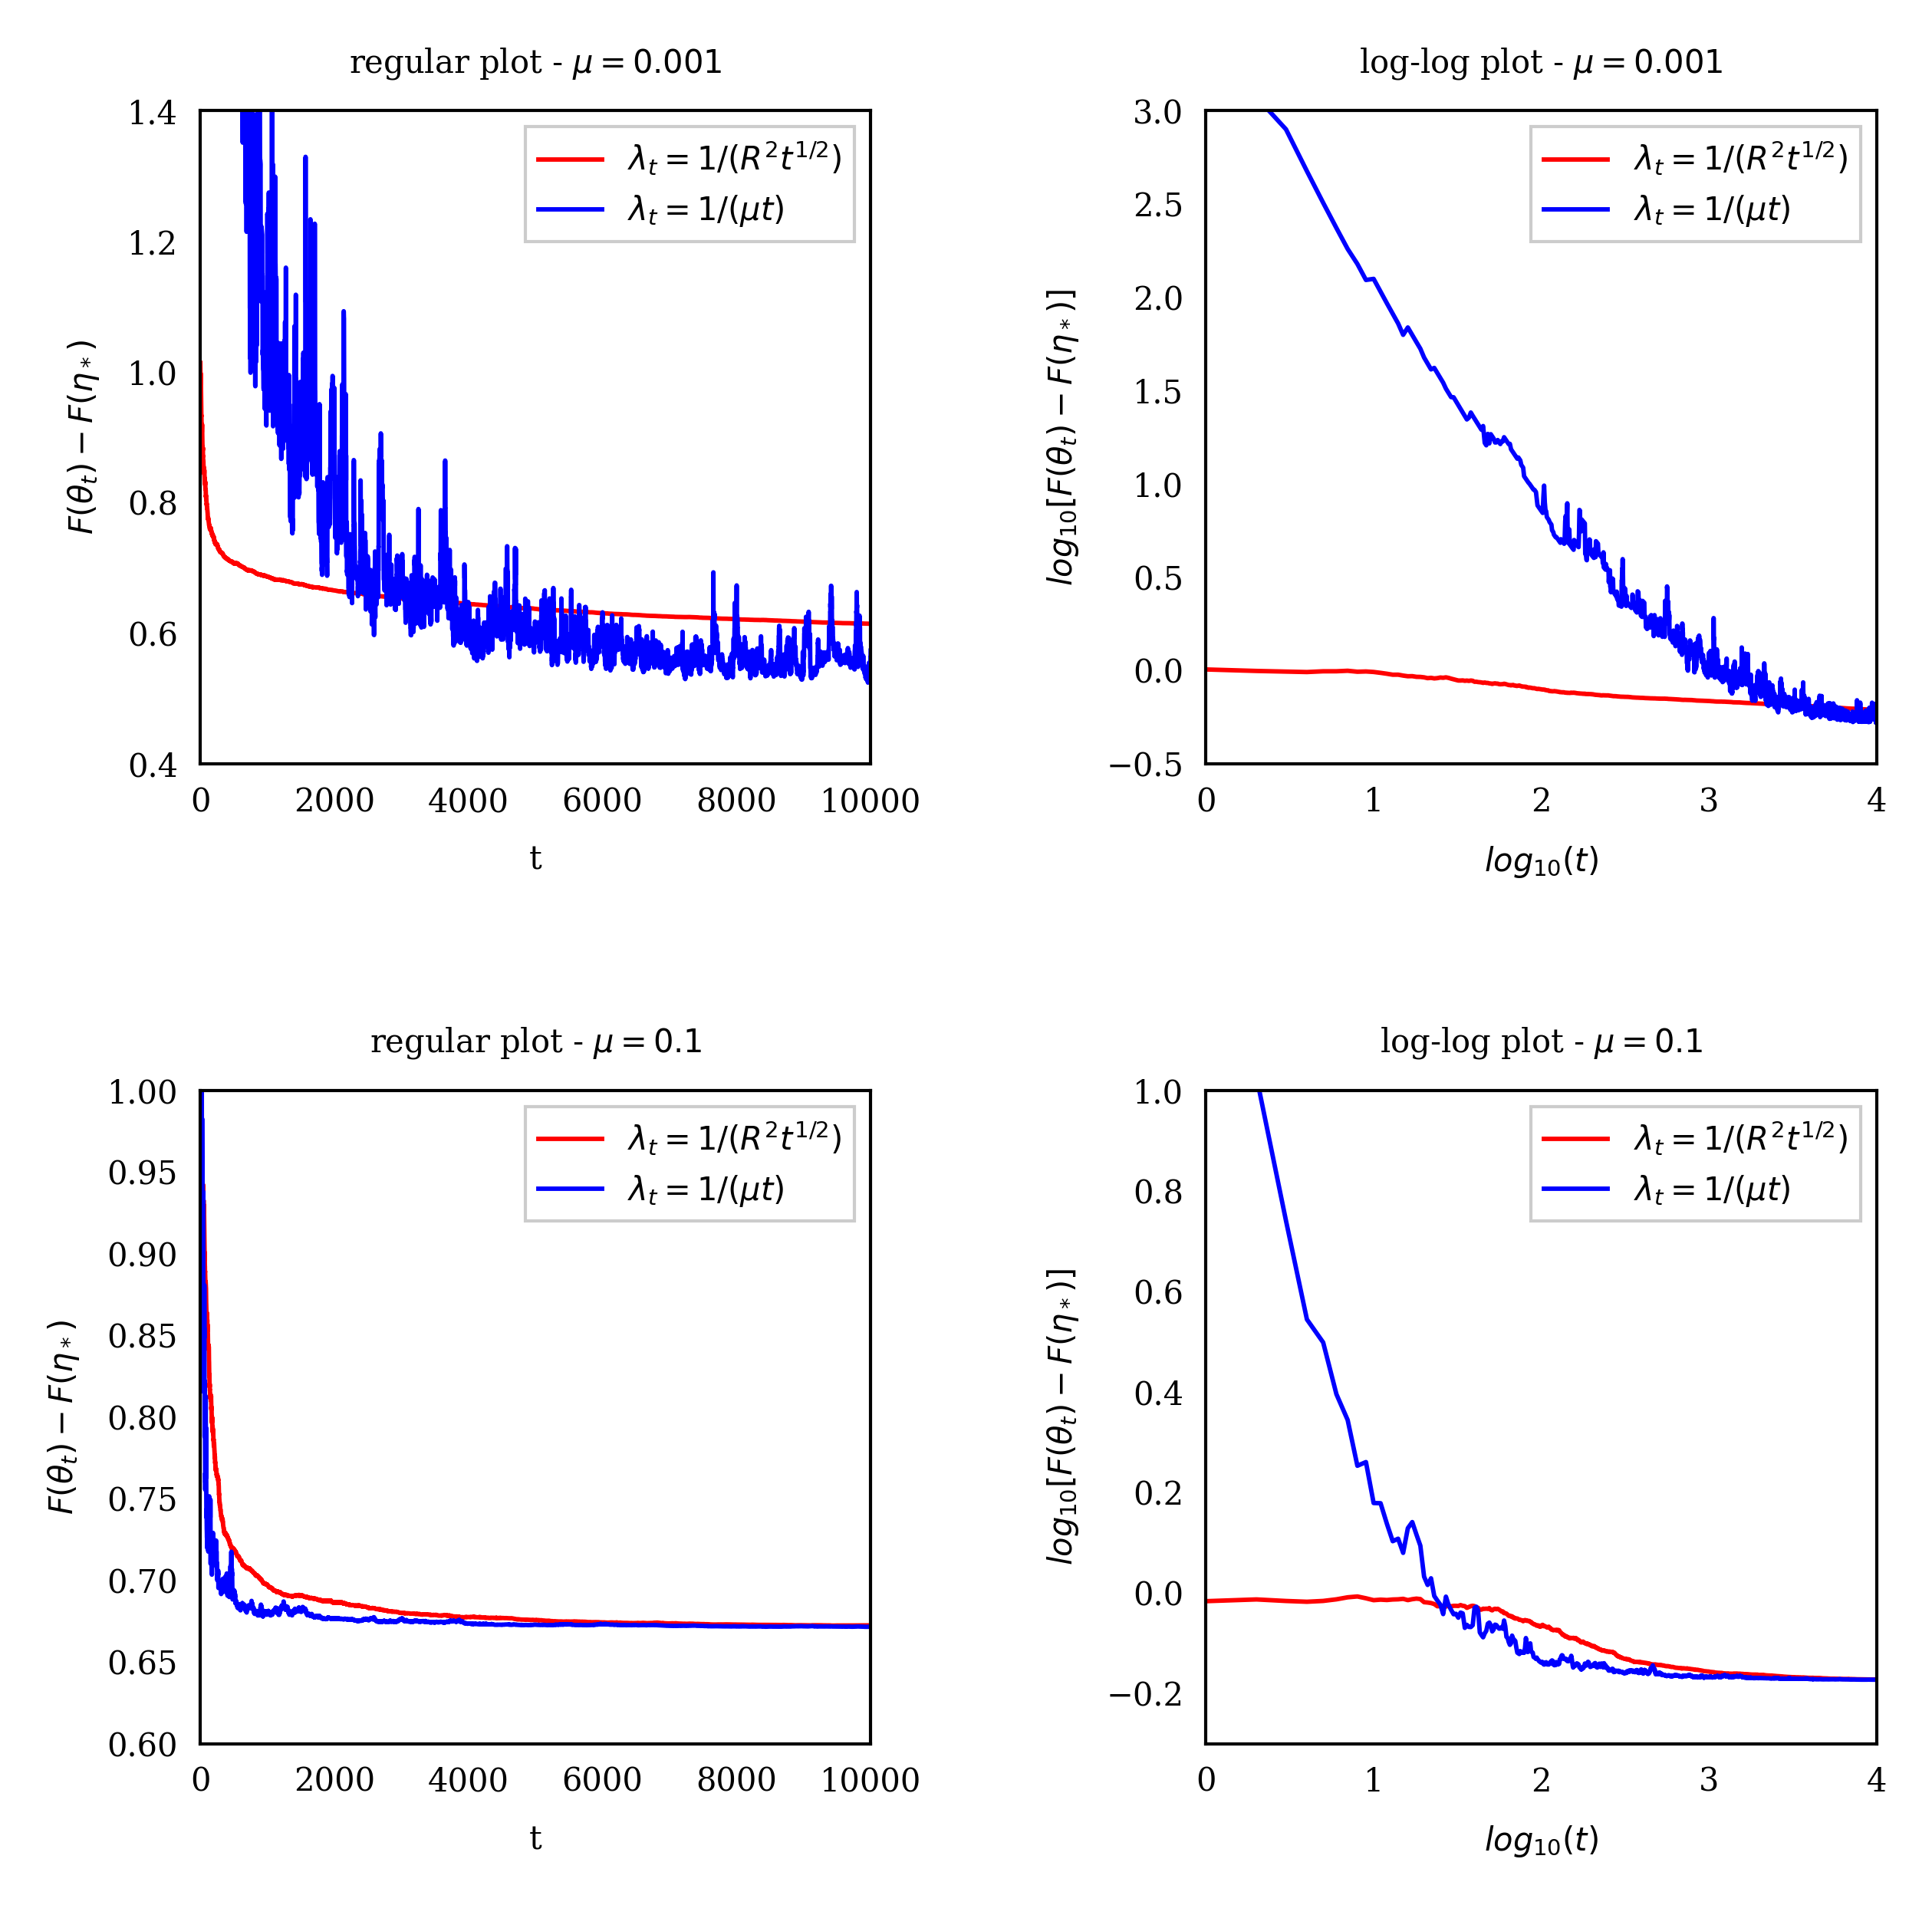

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = medium_square, gridspec_kw = inner_space)
l10 = np.log10

axs[0,0].plot(range(max_iter)[1:],(F1_R - F_nu1)[1:], color = 'r', label = '$\lambda_t = 1/(R^2 t^{1/2})$')
axs[0,0].plot(range(max_iter)[1:],(F1_mu - F_nu1)[1:], color = 'b', label = '$\lambda_t = 1/(\mu t)$')
axs[0,0].legend()
axs[0,0].set_ylim(0.4, 1.4)
axs[0,0].set_xlim(0, max_iter)
axs[0,0].set_title("regular plot - $\mu = 0.001$")
axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel('$F(\\theta_t) - F(\eta_*)$')

axs[0,1].plot(l10(range(max_iter)[1:]),l10((F1_R - F_nu1)[1:]), color = 'r', label = '$\lambda_t = 1/(R^2 t^{1/2})$')
axs[0,1].plot(l10(range(max_iter)[1:]),l10((F1_mu - F_nu1)[1:]), color = 'b', label = '$\lambda_t = 1/(\mu t)$')
axs[0,1].legend()
axs[0,1].set_ylim(-0.5,3)
axs[0,1].set_xlim(0, l10(max_iter))
axs[0,1].set_title("log-log plot - $\mu = 0.001$")
axs[0,1].set_xlabel("$log_{10}(t)$")
axs[0,1].set_ylabel('$log_{10}[F(\\theta_t) - F(\eta_*)]$')

axs[1,0].plot(range(max_iter)[1:],(F2_R - F_nu2)[1:], color = 'r', label = '$\lambda_t = 1/(R^2 t^{1/2})$')
axs[1,0].plot(range(max_iter)[1:],(F2_mu - F_nu2)[1:], color = 'b', label = '$\lambda_t = 1/(\mu t)$')
axs[1,0].legend()
axs[1,0].set_ylim(0.6,1)
axs[1,0].set_xlim(0, max_iter)
axs[1,0].set_title("regular plot - $\mu = 0.1$")
axs[1,0].set_xlabel("t")
axs[1,0].set_ylabel('$F(\\theta_t) - F(\eta_*)$')

axs[1,1].plot(l10(range(max_iter)[1:]),l10((F2_R - F_nu2)[1:]), color = 'r', label = '$\lambda_t = 1/(R^2 t^{1/2})$')
axs[1,1].plot(l10(range(max_iter)[1:]),l10((F2_mu - F_nu2)[1:]), color = 'b', label = '$\lambda_t = 1/(\mu t)$')
axs[1,1].legend()
axs[1,1].set_ylim(-0.3,1)
axs[1,1].set_xlim(0, l10(max_iter))
axs[1,1].set_title("log-log plot - $\mu = 0.1$")
axs[1,1].set_xlabel("$log_{10}(t)$")
axs[1,1].set_ylabel('$log_{10}[F(\\theta_t) - F(\eta_*)]$')

plt.savefig('fig52.svg')
files.download("fig52.svg")

plt.show()

#### Fig 5.3

<ipython-input-26-487d1d5bca46>:256: RuntimeWarning: divide by zero encountered in log10
  plt.plot((tostore)/n, np.log10(functionval_saga - optvalue), 'r')
<ipython-input-26-487d1d5bca46>:256: RuntimeWarning: invalid value encountered in log10
  plt.plot((tostore)/n, np.log10(functionval_saga - optvalue), 'r')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

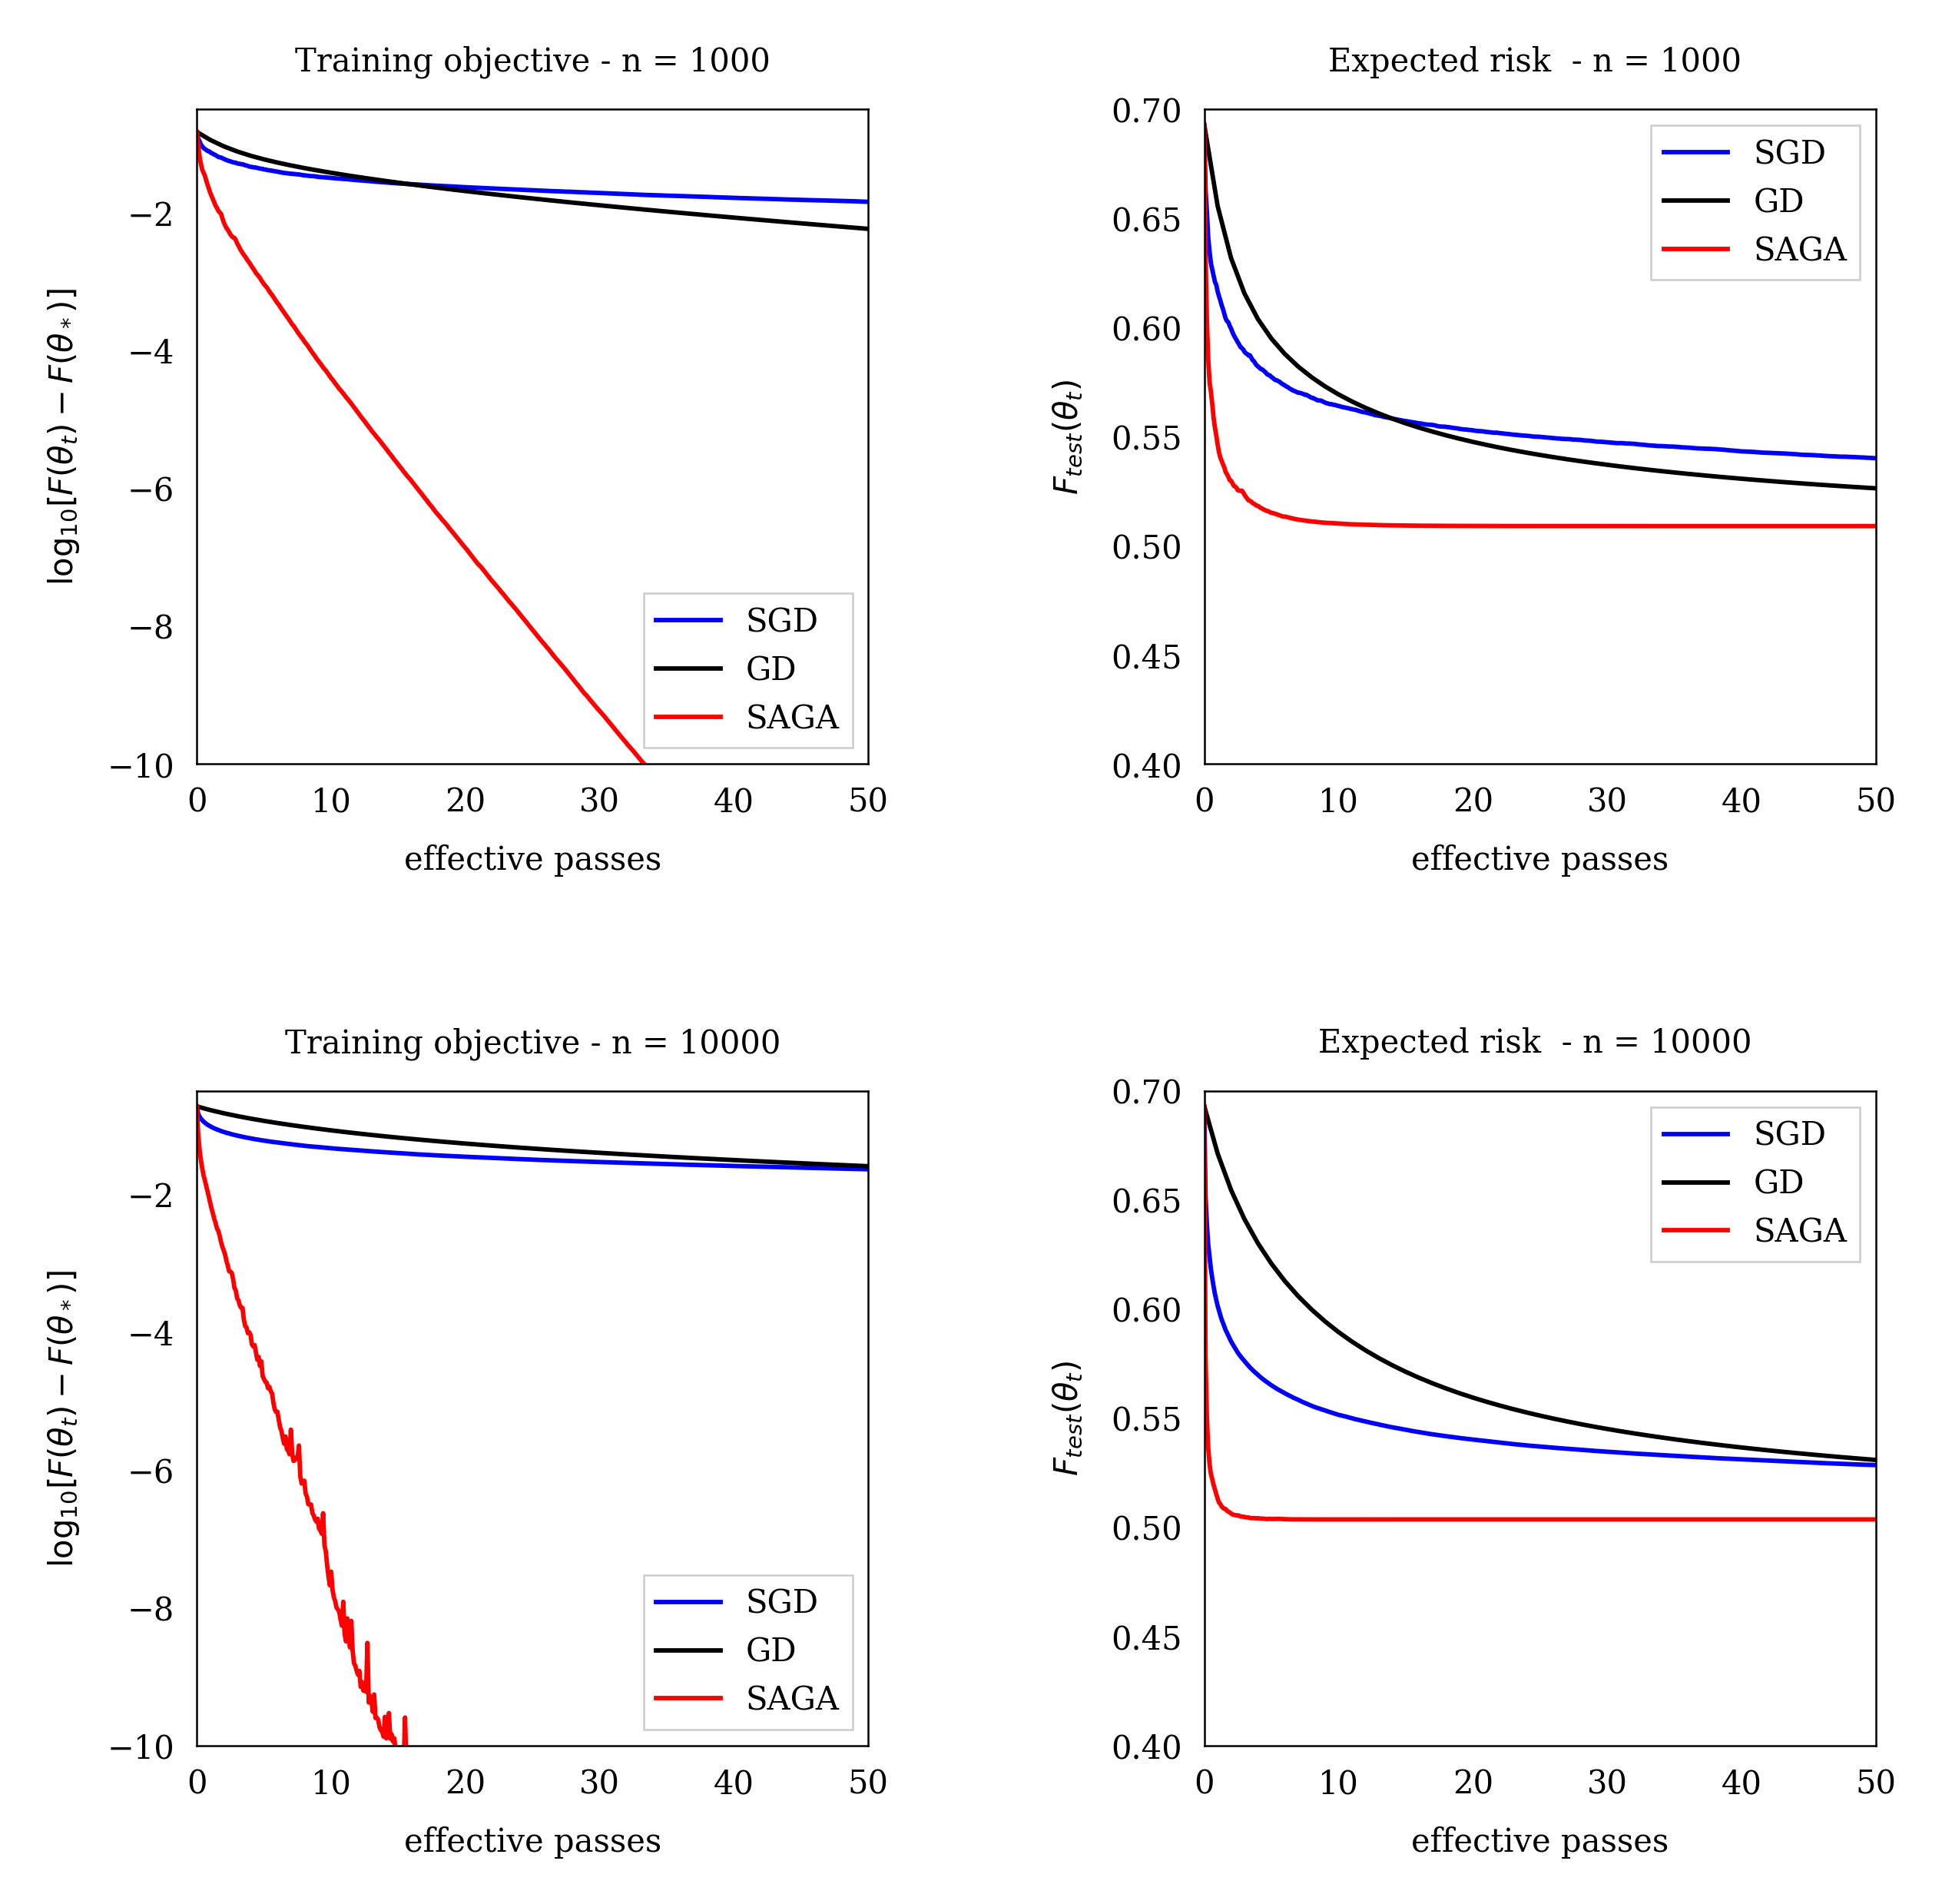

In [ ]:
# fixed matrix with planted singular values
d = 40
n = 2000

H = np.random.randn(d, d)
u, s, v = np.linalg.svd(H)
H = u @ np.diag(1./np.arange(1, d+1)) @ u.T
Hsqrt = sqrtm(H)

X = np.random.randn(n, d) @ Hsqrt
w0 = np.random.randn(d, 1)
w0 = w0 / np.sqrt(w0.T @ H @ w0)
noise_std = 1
y = np.sign(X @ w0 + noise_std * np.random.randn(n, 1))
R2 = np.max(np.sum(X**2, axis=1))
L = np.max(np.linalg.eig(X.T @ X / n)[0])
w = np.zeros((d, 1))

mu = 1e-2
mu = R2 / n
n = n // 2
Xtest = X[n:,:]
ytest = y[n:]
X = X[:n,:]
y = y[:n]

# SGD step
w = np.zeros((d, 1))
wave = np.zeros((d, 1))
number_of_passes = 50
tostore = np.arange(1, number_of_passes * n + 1, n//10)
tostore_ind = np.zeros(number_of_passes * n, dtype=bool)
tostore_ind[tostore] = True
maxiter_sto = number_of_passes * n

functionval_sc = np.zeros(maxiter_sto)
functionval_sc_ave = np.zeros(maxiter_sto)
functionval_sc_ave_test = np.zeros(maxiter_sto)
functionval_sc_test = np.zeros(maxiter_sto)

istore = 0
for iter in range(1, maxiter_sto + 1):
    if tostore_ind[iter - 1]:
        functionval_sc[istore] = np.mean(np.log(1 + np.exp(- y * X @ w ))) + mu / 2 * np.sum(w**2)
        functionval_sc_ave[istore] = np.mean(np.log(1 + np.exp(- y * X @ wave ))) + mu / 2 * np.sum(wave**2)
        functionval_sc_test[istore] = np.mean(np.log(1 + np.exp(- ytest * Xtest @ w )))
        functionval_sc_ave_test[istore] = np.mean(np.log(1 + np.exp(- ytest * Xtest @ wave )))
        istore += 1

    it = np.random.randint(n)
    temp = X[it,:] @ w * y[it]
    w = w.reshape(d,) - 1 / (R2 * np.sqrt(iter + 1) + mu * (iter + 1)) * (mu * w.reshape(d,) + X[it,:].T * (y[it] * (-1 / (1 + np.exp(temp)))))
    wave = (1 - 1 / iter) * wave.reshape(d,) + w.reshape(d,) / iter

functionval_sc=functionval_sc[:istore]
functionval_sc_ave=functionval_sc_ave[:istore]
functionval_sc_test=functionval_sc_test[:istore]
functionval_sc_ave_test=functionval_sc_ave_test[:istore]

#GD
w = np.zeros((d, 1))
maxiter_det = number_of_passes + 1
functionval_sc_det = np.zeros(maxiter_det)
functionval_sc_det_test = np.zeros(maxiter_det)

for iter in range(maxiter_det):
    temp = np.multiply(np.dot(X, w), y)
    functionval_sc_det[iter] = np.mean(np.log(1 + np.exp(-y * (np.dot(X, w))))) + mu/2 * np.sum(np.square(w))
    functionval_sc_det_test[iter] = np.mean(np.log(1 + np.exp(-ytest * (np.dot(Xtest, w)))))

    grad = mu * w + (1/n) * np.dot(np.transpose(X), np.multiply(y, -1 / (1 + np.exp(temp))))
    w = w - (1/L) * grad

# SAGA
w = np.zeros((d, 1))

tostore = np.arange(1, number_of_passes * n + 1, n//10)
tostore_ind = np.zeros(number_of_passes * n * 4, dtype=bool)
tostore_ind[tostore] = True

temp = np.multiply((X @ w).reshape(n,), y.reshape(n,))
zs = np.multiply(X.T, np.repeat( (np.multiply(y.reshape(n,),(-1 / (1 + np.exp(temp))))).reshape(1, n), d, axis=0)) + np.repeat(mu * w, n,axis=1)
meanzs = np.mean(zs, axis=1)

maxiter_saga = number_of_passes * n * 2
functionval_saga = np.zeros(maxiter_saga)
functionval_saga_test = np.zeros(maxiter_saga)
istore = 0

for iter in range(maxiter_saga):
    if tostore_ind[iter]:
        functionval_saga[istore] = np.mean(np.log(1 + np.exp(np.multiply(-y.reshape(n,), (X @ w).reshape(n,))))) + (mu/2) * np.sum(w**2)
        functionval_saga_test[istore] = np.mean(np.log(1 + np.exp(np.multiply(-ytest.reshape(n,) , (Xtest @ w).reshape(n,)))))
        istore += 1

    if iter == maxiter_saga - 1:
        optvalue = np.mean(np.log(1 + np.exp(np.multiply(-y.reshape(n,), (X @ w).reshape(n,))))) + (mu/2) * np.sum(w**2)

    it = np.random.randint(n)
    temp = np.multiply((X[it, :] @ w), y[it])
    gradloc = (mu * w.reshape(d,) + np.multiply(X[it, :].T , (y[it] * (-1 / (1 + np.exp(temp))))))
    w = w.reshape(d,) - 1 / (3 * R2) * (gradloc.reshape(d,) - zs[:, it] + meanzs.reshape(d,))
    meanzs = meanzs.reshape(d,) + gradloc.reshape(d,)/n - zs[:, it]/n
    zs[:, it] = gradloc.reshape(d,)

functionval_saga=functionval_saga[:istore]
functionval_saga_test=functionval_saga_test[:istore]

fig, axs = plt.subplots(2, 2, figsize = medium_square, gridspec_kw = inner_space)

plt.sca(axs[0,1])
plt.plot((tostore)/n, functionval_sc_test ,'b')
plt.plot(range(maxiter_det), functionval_sc_det_test, 'k')
plt.plot((tostore)/n, functionval_saga_test, 'r')
plt.legend(['SGD','GD','SAGA'], loc='upper right')
plt.xlabel('effective passes')
plt.ylabel('$F_{test}(\\theta_t)$')
plt.title('Expected risk  - n = 1000 ')
plt.xlim(0, number_of_passes)
plt.ylim(0.4, 0.7)

plt.sca(axs[0,0])
plt.plot((tostore)/n, np.log10(functionval_sc - optvalue), 'b')
plt.plot(range(maxiter_det), np.log10(functionval_sc_det - optvalue), 'k')
plt.plot((tostore)/n, np.log10(functionval_saga - optvalue), 'r')
plt.legend(['SGD','GD','SAGA'], loc='lower right')
plt.xlabel('effective passes')
plt.ylabel('$\\log_{10}[F(\\theta_t) - F(\\theta_*)]$')
plt.title('Training objective - n = 1000')
plt.xlim(0, number_of_passes)
plt.ylim(-10, -0.5)

# fixed matrix with planted singular values
d = 40
n = 20000

H = np.random.randn(d, d)
u, s, v = np.linalg.svd(H)
H = u @ np.diag(1./np.arange(1, d+1)) @ u.T
Hsqrt = sqrtm(H)

X = np.random.randn(n, d) @ Hsqrt
w0 = np.random.randn(d, 1)
w0 = w0 / np.sqrt(w0.T @ H @ w0)
noise_std = 1
y = np.sign(X @ w0 + noise_std * np.random.randn(n, 1))
R2 = np.max(np.sum(X**2, axis=1))
L = np.max(np.linalg.eig(X.T @ X / n)[0])
w = np.zeros((d, 1))

mu = 1e-2
mu = R2 / n
n = n // 2
Xtest = X[n:,:]
ytest = y[n:]
X = X[:n,:]
y = y[:n]

# SGD step
w = np.zeros((d, 1))
wave = np.zeros((d, 1))
number_of_passes = 50
tostore = np.arange(1, number_of_passes * n + 1, n//10)
tostore_ind = np.zeros(number_of_passes * n, dtype=bool)
tostore_ind[tostore] = True
maxiter_sto = number_of_passes * n

functionval_sc = np.zeros(maxiter_sto)
functionval_sc_ave = np.zeros(maxiter_sto)
functionval_sc_ave_test = np.zeros(maxiter_sto)
functionval_sc_test = np.zeros(maxiter_sto)

istore = 0
for iter in range(1, maxiter_sto + 1):
    if tostore_ind[iter - 1]:
        functionval_sc[istore] = np.mean(np.log(1 + np.exp(- y * X @ w ))) + mu / 2 * np.sum(w**2)
        functionval_sc_ave[istore] = np.mean(np.log(1 + np.exp(- y * X @ wave ))) + mu / 2 * np.sum(wave**2)
        functionval_sc_test[istore] = np.mean(np.log(1 + np.exp(- ytest * Xtest @ w )))
        functionval_sc_ave_test[istore] = np.mean(np.log(1 + np.exp(- ytest * Xtest @ wave )))
        istore += 1

    it = np.random.randint(n)
    temp = X[it,:] @ w * y[it]
    w = w.reshape(d,) - 1 / (R2 * np.sqrt(iter + 1) + mu * (iter + 1)) * (mu * w.reshape(d,) + X[it,:].T * (y[it] * (-1 / (1 + np.exp(temp)))))
    wave = (1 - 1 / iter) * wave.reshape(d,) + w.reshape(d,) / iter

functionval_sc=functionval_sc[:istore]
functionval_sc_ave=functionval_sc_ave[:istore]
functionval_sc_test=functionval_sc_test[:istore]
functionval_sc_ave_test=functionval_sc_ave_test[:istore]

#GD
w = np.zeros((d, 1))
maxiter_det = number_of_passes + 1
functionval_sc_det = np.zeros(maxiter_det)
functionval_sc_det_test = np.zeros(maxiter_det)

for iter in range(maxiter_det):
    temp = np.multiply(np.dot(X, w), y)
    functionval_sc_det[iter] = np.mean(np.log(1 + np.exp(-y * (np.dot(X, w))))) + mu/2 * np.sum(np.square(w))
    functionval_sc_det_test[iter] = np.mean(np.log(1 + np.exp(-ytest * (np.dot(Xtest, w)))))

    grad = mu * w + (1/n) * np.dot(np.transpose(X), np.multiply(y, -1 / (1 + np.exp(temp))))
    w = w - (1/L) * grad

# SAGA
w = np.zeros((d, 1))

tostore = np.arange(1, number_of_passes * n + 1, n//10)
tostore_ind = np.zeros(number_of_passes * n * 4, dtype=bool)
tostore_ind[tostore] = True

temp = np.multiply((X @ w).reshape(n,), y.reshape(n,))
zs = np.multiply(X.T, np.repeat( (np.multiply(y.reshape(n,),(-1 / (1 + np.exp(temp))))).reshape(1, n), d, axis=0)) + np.repeat(mu * w, n,axis=1)
meanzs = np.mean(zs, axis=1)

maxiter_saga = number_of_passes * n * 2
functionval_saga = np.zeros(maxiter_saga)
functionval_saga_test = np.zeros(maxiter_saga)

istore = 0
for iter in range(maxiter_saga):
    if tostore_ind[iter]:
        functionval_saga[istore] = np.mean(np.log(1 + np.exp(np.multiply(-y.reshape(n,), (X @ w).reshape(n,))))) + (mu/2) * np.sum(w**2)
        functionval_saga_test[istore] = np.mean(np.log(1 + np.exp(np.multiply(-ytest.reshape(n,) , (Xtest @ w).reshape(n,)))))
        istore += 1

    if iter == maxiter_saga - 1:
        optvalue = np.mean(np.log(1 + np.exp(np.multiply(-y.reshape(n,), (X @ w).reshape(n,))))) + (mu/2) * np.sum(w**2)

    it = np.random.randint(n)
    temp = np.multiply((X[it, :] @ w), y[it])
    gradloc = (mu * w.reshape(d,) + np.multiply(X[it, :].T , (y[it] * (-1 / (1 + np.exp(temp))))))
    w = w.reshape(d,) - 1 / (3 * R2) * (gradloc.reshape(d,) - zs[:, it] + meanzs.reshape(d,))
    meanzs = meanzs.reshape(d,) + gradloc.reshape(d,)/n - zs[:, it]/n
    zs[:, it] = gradloc.reshape(d,)

functionval_saga=functionval_saga[:istore]
functionval_saga_test=functionval_saga_test[:istore]


plt.sca(axs[1,1])
plt.plot((tostore)/n, functionval_sc_test ,'b')
plt.plot(range(maxiter_det), functionval_sc_det_test, 'k')
plt.plot((tostore)/n, functionval_saga_test, 'r')
plt.legend(['SGD','GD','SAGA'], loc='upper right')
plt.xlabel('effective passes')
plt.ylabel('$F_{test}(\\theta_t)$')
plt.title('Expected risk  - n = 10000 ')
plt.xlim(0, number_of_passes)
plt.ylim(0.4, 0.7)

plt.sca(axs[1,0])
plt.plot((tostore)/n, np.log10(functionval_sc - optvalue), 'b')
plt.plot(range(maxiter_det), np.log10(functionval_sc_det - optvalue), 'k')
plt.plot((tostore)/n, np.log10(functionval_saga - optvalue), 'r')
plt.legend(['SGD','GD','SAGA'], loc='lower right')
plt.xlabel('effective passes')
plt.ylabel('$\\log_{10}[F(\\theta_t) - F(\\theta_*)]$')
plt.title('Training objective - n = 10000')
plt.xlim(0, number_of_passes)
plt.ylim(-10, -0.5)

plt.savefig('fig53.svg')
files.download("fig53.svg")

plt.show()